In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import pickle
%matplotlib inline
import os

In [ ]:
## Example ##


image Shape (720, 1280, 3)


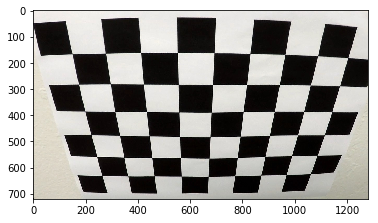

In [2]:
img = mpimg.imread('camera_cal/calibration2.jpg')
image_shape = img.shape
print("image Shape",image_shape)
plt.imshow(img)

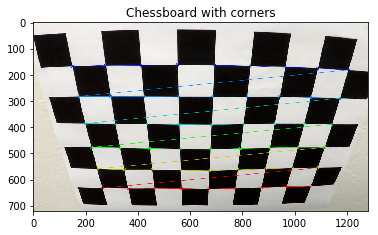

In [3]:
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard with corners")
    plt.show()

In [4]:
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)

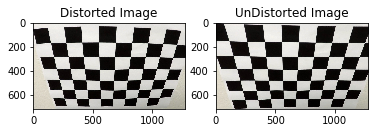

In [5]:
img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot()
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Distorted Image")
plt.subplot(1,2,2)
plt.imshow(undistorted)
plt.title("UnDistorted Image")

In [6]:
def undistortImage(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img
        
    
    

In [7]:
## HLS trasnformations:
def hls_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    thresh = (160, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return s_binary

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


In [9]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [10]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [11]:
def sobelCombined(sx_binary,sy_binary, dir_binary,mag_binary):
    combined = np.zeros_like(dir_binary)
    combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    

In [12]:
def sobel_schannel_combined(sobelCombined,s_binary):
    combined_binary = np.zeros_like(sobelCombined)
    combined_binary[(s_binary == 1) | (sobelCombined == 1)] = 1
    
    return combined_binary



In [13]:
def perspectiveTransform(img,gaussian_combined_binary):
    image_shape=img.shape
    img_size = (image_shape[1], image_shape[0])
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    src = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(gaussian_combined_binary, M, img_size)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(copy)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped Image', fontsize=10)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    return warped,Minv


In [14]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [15]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def sliding_window(binary_warped,Minv,img,undist):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.show()

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)

    
    
   

In [16]:
def pipeline(image):
    s_binary=hls_binary(img)
    undistImg=undistortImage(img)
    gray = cv2.cvtColor(undistImg, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    sx_binary=abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=100)
    sy_binary=abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=100)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray,sobel_kernel=15,thresh=(0.7, 1.3))
    mag_binary=mag_thresh(gray, sobel_kernel=15, mag_thresh=(30, 100))
    
    sobelCombined_binary=sobelCombined(sx_binary,sy_binary, dir_binary,mag_binary)
    
    combined_binary=sobel_schannel_combined(sobelCombined_binary,s_binary)
    gaussian_combined_binary=gaussian_blur(combined_binary, 5)
    
    #f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 5))
    #f, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(1, 5, figsize=(10, 5))
    #f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(10, 5))
    #f, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(10, 5))
   
    
    #ax2.set_title('Transformed', fontsize=20)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img,cmap="gray")
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(sobelCombined_binary,cmap="gray")
    ax2.set_title('sobelCombined_binary', fontsize=10)
    ax3.imshow(s_binary,cmap="gray")
    ax3.set_title('s_binary Image', fontsize=10)
    ax4.imshow(gaussian_combined_binary,cmap="gray")
    ax4.set_title('gaussian_combined_binary Image', fontsize=10)
    #ax5.imshow(gaussian_combined_binary,cmap="gray")
    #ax5.set_title('gaussian_combined_binary Image', fontsize=10)
    #ax6.imshow(sy_binary,cmap="gray")
    #ax6.set_title('sy_binary Image', fontsize=10)
    #ax7.imshow(s_binary,cmap="gray")
    #ax7.set_title('s_binary Image', fontsize=10)
    #ax8.imshow(combined_binary,cmap="gray")
    #ax8.set_title('combined_binary Image', fontsize=10)
    #ax9.imshow(img,cmap="gray")
    #ax9.set_title('Original Image', fontsize=10)
    plt.show()
    warped_image,Minv=perspectiveTransform(img,gaussian_combined_binary)
    
    
    
    return warped_image,Minv,undistImg

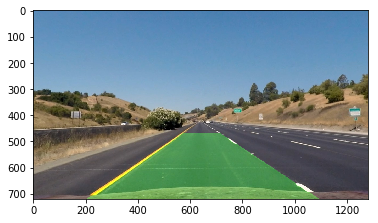

--------------------------------


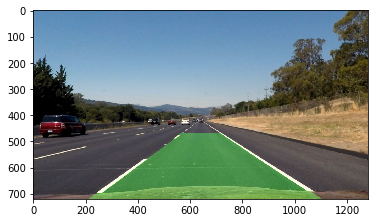

--------------------------------


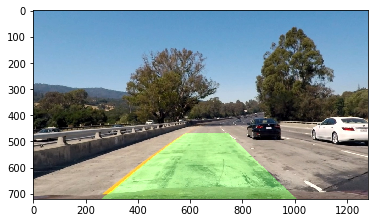

--------------------------------


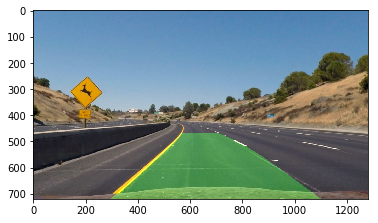

--------------------------------


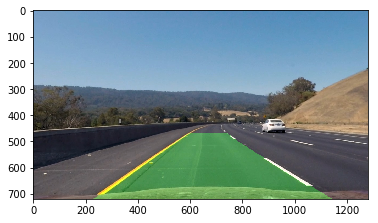

--------------------------------


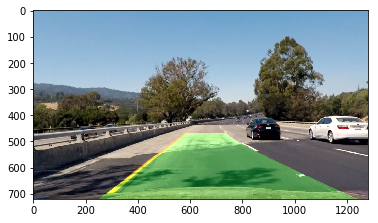

--------------------------------


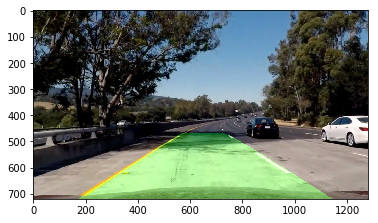

--------------------------------


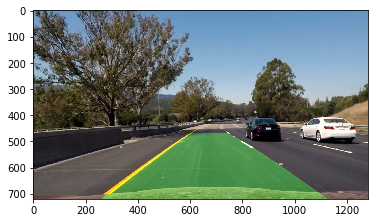

--------------------------------


In [20]:
images = os.listdir('./test_images')  
for image in images:
    image = os.path.join('test_images',image)
    #print(image)
    img = mpimg.imread(image)
    #img = cv2.resize(img, (720, 405))
    result=pipeline_video(image)
    #sliding_window(np.uint8(warped_image*255),Minv,img,undistImg)
    plt.imshow(result)
    plt.show()
    print("--------------------------------")
    
    

In [ ]:
img = mpimg.imread('test_images/test4.jpg')
image_shape = img.shape
print("image Shape",image_shape)
 
s_binary=hls_binary(img)
undistImg=undistortImage(img)
gray = cv2.cvtColor(undistImg, cv2.COLOR_RGB2GRAY)
height, width = gray.shape
sx_binary=abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=100)
sy_binary=abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=100)
    
# apply gradient direction threshold so that only edges closer to vertical are detected.
dir_binary = dir_threshold(gray,sobel_kernel=15,thresh=(0.7, 1.3))
mag_binary=mag_thresh(gray, sobel_kernel=15, mag_thresh=(30, 100))
    
sobelCombined_binary=sobelCombined(sx_binary,sy_binary, dir_binary,mag_binary)
    
combined_binary=sobel_schannel_combined(sobelCombined_binary,s_binary)
gauss_img=gaussian_blur(combined_binary, 5) 


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(sx_binary,cmap="gray")
ax1.set_title('sx_binary Image', fontsize=20)
ax2.imshow(s_binary,cmap="gray")
ax2.set_title('s_binary', fontsize=20)
ax3.imshow(combined_binary,cmap="gray")
ax3.set_title('combined_binary Image', fontsize=10)
ax4.imshow(gauss_img,cmap="gray")
ax4.set_title('gauss_img Image', fontsize=10)
plt.show()
print("--------------------------------")
warped_img=perspectiveTransform(img,gauss_img)
sliding_window(np.uint8(warped_img*255))

In [17]:
def pipeline_video(image):
    s_binary=hls_binary(img)
    undistImg=undistortImage(img)
    gray = cv2.cvtColor(undistImg, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    sx_binary=abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=100)
    sy_binary=abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=100)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray,sobel_kernel=15,thresh=(0.7, 1.3))
    mag_binary=mag_thresh(gray, sobel_kernel=15, mag_thresh=(30, 100))
    
    sobelCombined_binary=sobelCombined(sx_binary,sy_binary, dir_binary,mag_binary)
    
    combined_binary=sobel_schannel_combined(sobelCombined_binary,s_binary)
    gaussian_combined_binary=gaussian_blur(combined_binary, 5)
    
    #f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 5))
    #f, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(1, 5, figsize=(10, 5))
    #f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(10, 5))
    #f, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(10, 5))
   
    
    
    warped_image,Minv=perspectiveTransform_video(img,gaussian_combined_binary)
    
    result=sliding_window_video(np.uint8(warped_image*255),Minv,img,undistImg)
    
    return result
    
    
    

In [18]:
def perspectiveTransform_video(img,gaussian_combined_binary):
    image_shape=img.shape
    img_size = (image_shape[1], image_shape[0])
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    src = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(gaussian_combined_binary, M, img_size)
    
    return warped,Minv

In [19]:
def sliding_window_video(binary_warped,Minv,img,undist):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.show()

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


In [ ]:
import numpy as np
histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [22]:
from moviepy.editor import VideoFileClip

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|████████████████▏                                                                                                                | 47/376 [00:29<03:34,  1.54it/s]


 25%|████████████████████████████████▌                                                                                                | 95/376 [01:04<03:33,  1.32it/s]


 38%|████████████████████████████████████████████████▋                                                                               | 143/376 [01:38<03:08,  1.23it/s]


 51%|█████████████████████████████████████████████████████████████████                                                               | 191/376 [02:07<01:54,  1.61it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 239/376 [02:37<01:38,  1.39it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 287/376 [03:09<00:55,  1.61it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 335/376 [03:43<00:29,  1.39it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 375/376 [04:09<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 11s
